In [2]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

dataset used is spam email dataset from the HP Lab to predict if an email is spam. The dataset contains 4601 email items, of which 1813 items were identified as spam

#### For starters, moving on without feature engineering

### The dataset contains the following features:
#### crl.tot
total length of words in capitals

#### dollar
number of occurrences of the \$ symbol

#### bang
number of occurrences of the ! symbol

#### money
number of occurrences of the word ‘money’

#### n000
number of occurrences of the string ‘000’

#### make
number of occurrences of the word ‘make’

#### yesno
outcome variable, a factor with levels n not spam, y spam

### Importing dataset and summary statistic

In [3]:
ds=pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
ds['spam'] = ds['yesno'].map({'y': 1, 'n': 0})
ds = ds.drop(['Unnamed: 0','yesno',], axis=1)

ds.head()

,crl.tot,dollar,bang,money,n000,make,spam
0,278,0.000,0.778,0.00,0.00,0.00,1
1,1028,0.180,0.372,0.43,0.43,0.21,1
2,2259,0.184,0.276,0.06,1.16,0.06,1
3,191,0.000,0.137,0.00,0.00,0.00,1
4,191,0.000,0.135,0.00,0.00,0.00,1


In [4]:
ds.mean()

crl.tot    283.289285
dollar       0.075811
bang         0.269071
money        0.094269
n000         0.101645
make         0.104553
spam         0.394045
dtype: float64

The descriptive statistics below give a first idea on which features are correlated with spam emails. Everything related to money (dollar, money, n000) is strongly correlated with spam. Spammers use more words in capitals and the word "make" as well as exclamation points more frequently.

In [5]:
ds.groupby(['spam']).mean()

,crl.tot,dollar,bang,money,n000,make
spam,,,,,,
0,161.470947,0.011648,0.109984,0.017138,0.007088,0.073479
1,470.619415,0.174478,0.513713,0.212879,0.247055,0.152339


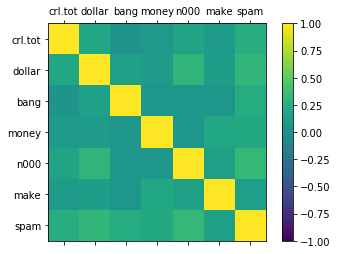

,crl.tot,dollar,bang,money,n000,make,spam
crl.tot,1.000000,0.201948,0.036321,0.080993,0.165977,0.089165,0.249164
dollar,0.201948,1.000000,0.142913,0.104691,0.310971,0.117419,0.323629
bang,0.036321,0.142913,1.000000,0.051076,0.070103,0.058292,0.241888
money,0.080993,0.104691,0.051076,1.000000,0.052587,0.188155,0.216111
n000,0.165977,0.310971,0.070103,0.052587,1.000000,0.134072,0.334787
make,0.089165,0.117419,0.058292,0.188155,0.134072,1.000000,0.126208
spam,0.249164,0.323629,0.241888,0.216111,0.334787,0.126208,1.000000


In [6]:
correlations = ds.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(ds)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations